# **Recuperando el coeficiente de difusión**
## **Sistemas multiradiales**

**Contexto del problema**:

**Objetivos**:

**Recomendaciones**:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
from scipy.optimize import curve_fit, least_squares
from scipy.linalg import solve
import ipywidgets as widgets
#from ipywidgets import AppLayout, FloatSlider
#import mpl_interactions.ipyplot as iplt
#matplotlib widget
#%matplotlib ipympl
from scipy.integrate import simps
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline

## Método de Grunwald

En el trabajo de P. Grunwald se propone un método experimental para estudiar el proceso de difusión de en reacción que involucren enzimas o células (?) inmobilizadas. El experimento a grandes rasgos considera la dinámica de la concentración de un sustrato de un sistema de un inmobilizador en un medio líquido. Las hipótesis son las siguientes
- La geometría del inmobilizador es esférica
- Low molecular weight (?)
- El comportamiento de la concentración del sustrato en el inmobilizador solo depende del radio
- La difusión en el medio líquido es instantánea (duda? las mediciones se hacen en el líquido no ?)

El proceso de difusión que a nosotros nos interesa es el de difusión externa es decir, aquel en que solo el inmobilizador contiene sustrato al comienzo del experimento. En este caso el modelo en evolución de la concentración del sustrato en el borde viene dada por 

$$\begin{align}
    \label{S_b_grun}
    S_b(t) = c_\infty + (c_0-c_\infty)\dfrac{6}{\pi}\sum_{n\in \mathbb{N}}\dfrac{1}{n^2}e^{-n^2\pi^2Dt/R^2},\quad t\geq 0
\end{align}$$

donde $c_\infty$ y $c_0$ son la concentración inicial y final en el inmobilizador, $R$ es el radio del inmobilizador y $D$ es el coeficiente de difusión. Las mediciones experimentales para encontrar el parámetro $D$ se realizan en el medio líquido el cual por la cuarta hipótesis también será modelado por la función $S_B$. 

In [2]:
def func(t, D):
    f = np.ones(t.shape)*c_inf
    for i in range(1,n+1):
        f += (c_0-c_inf)*(6/(np.pi**2))*(1/i**2)*np.exp(-(i**2)*np.pi**2*D*t/(R**2)) 
    return f

In [3]:
def errM2(f,g):
    return ((f-g)**2).sum()

In [4]:
def func1(t, D, n, R, c_0, c_inf):#, c_0=0, c_inf=1, R=162*10**(-6), n=3):
    f = np.ones(t.shape)*c_inf
    for i in range(1,int(n)+1):
        f += (c_0-c_inf)*(6/(np.pi**2))*(1/i**2)*np.exp(-(i**2)*np.pi**2*D*t/(R**2)) 
        #print(f)
    return f

## Ecuación de difusión multiradio

### Motivación ### 

Bajo las supociones del método de Grunwald el comportamiento de la concentración $S$ de un sustrato dado se puede modelar via la EDP

$$\begin{align}
        \label{edplin} 
        \left\{
        \begin{array}{rcll}
            \partial_tS=D\left(\partial_{rr}^2S+\dfrac{2}{r}\partial_rS\right)  &\textrm{ en }&(0, T)\times (0, R)\\
            S(t, R)=S_b(t),\ \partial_rS(t, 0)=0 &\textrm{en}& (0, T)\\
            S(0, r)=S_0(r)  &\textrm{en}& (0, R).
        \end{array}
        \right.
        \tag{1}
    \end{align}$$

donde $S_0$ es la concentración radial inicial.
> **Interpretación física** 
> 1. La Ley de Fick asegura que la difusión se puede modelar por $S_t = D \Delta S$ lo que coincide para concentraciones radiales al realizar un cambio de variables a coordenadas esféricas,
> 2. $S(t,R)$ es el comportamiento temporal de la concentración en el borde,
> 3. $S_r(t,0)=0$ nos dice que no existe flujo de sustrato en el centro de la esfera.

Notemos que el funcional $J$ del método de Grunwald puede ser reinterpretado de manera continua para así obtener

$$ \begin{align}
    \label{min}
    \tag{2}
    \min_{D\in \mathbb{R}^+} \int_0^T|S_b(t)-g(t)|^2dt
\end{align}
$$

donde $g$ representa la información experimental. 

### Modelo a estudiar ###

Notemos que la EDP presentada en (1) tiene como parámetro la función $S_b$ por lo que conocer su solución no aportará información a la resolución del problema de minimización (2). En vista de esto tendremos que asumir a $S_b$ una función desconocida por lo que acoplaremos su dinámica al comportamiento de la concentración $S$ al intererior del inmobilizador para esto utilizaremos la ecuación de continuidad de la masa. Las hipótesis que se agregará será la siguiente

1. Los inmobilizadores son múltiples y tienen una cantidad finita de radios distintos los cuales son conocidos junto con su proporción

para aterrizar esta idea nos serán de utilidad los siguientes parámetros

$$\begin{align}
    &V_b: \text{ Volumen del medio líquido}\\
    &V_c: \text{ Volumen del conjunto de inmobilizadores}\\
    &n_r: \text{Número de radios distintos}\\
    &p_i: \text{Proporción de las partículas con radio } R_i \text{ con } i =1,...,n_r
\end{align}$$

**Continuidad de la masa**

La ecuación de continuidad de la masa que se transporta entre los inmobilizadores y el medio líquido está dada por

$$\begin{align}
 \dfrac{dm}{dt} + \sum_{i=1}^{n_r}n_i\iint_{\partial B_i} j_i d\sigma = M
\end{align}
$$

donde $m$ representa la masa, $j$ su flujo, $\partial B_i$ la superficie de un inmobilizador de radio $i$ (como la difusión en el agua es instantanea, entonces la posición de cada partícula no importa y se pueden considerar todas con su propio sistema de coordenadas independientes entre si) y $M$ el cambio de la masa que entra o sale del sistema. En nuestro caso 

1. $m(t,R) = V_bS_b(t)$
2. $j_i(t,R) = D\partial_n S^{(i)}(t,\sigma_i) = D\partial_r S^{(i)}(t,R)$ donde $S^{(i)}$ es la concentración del sustrato en cada inmobilizador de radio $R_i$ y $\sigma_i\in \partial B_i$
3. $M = 0$

Si asumimos que existen $n$ inmobilizadores como son todos de igual radio es válido 

$$ \begin{align}
    \sum_{i=1}^{n_r}n_i\iint_{\partial B_i} j_i d\sigma = 4\pi n D\sum_{i=1}^{n_r} p_iR_i^2 \partial_r S^{(i)}(t,R_i)
\end{align}
$$

además 


$$ \begin{align}
    n = \dfrac{3V_c}{4\pi \sum_{i=1}^{n_r}R_i^3p_i}
\end{align}
$$

entonces


$$ \begin{align}
     \dfrac{dm}{dt} +\dfrac{3DV_c}{ \sum_{i=1}^{n_r}R_i^3p_i}\sum_{i=1}^{n_r} p_iR_i^2 \partial_r S^{(i)}(t,R_i) = 0
\end{align}
$$

por lo que si hacemos $c = \dfrac{3DV_c}{ Vb\sum_{i=1}^{n_r}R_i^3p_i}$ y dividimos la ecuación anterior por $V_b$ obtenemos

$$ \begin{align}
    \tag{3}
     S_b'(t) = -c\sum_{i=1}^{n_r} p_iR_i^2 \partial_r S^{(i)}(t,R_i)
\end{align}
$$

**Sistema acoplado**

En este caso debemos resolver la ecuación de difusión para cada inmobilizador, al igual que antes basta tomar un representante por radio y acoplar la ecuación de continuidad por lo que tendremos un sistema de $nr +1$ ecuaciones de las cuales $n_r$ son EDP y $1$ es una EDO. 

$$\begin{align}
    \label{edpedolin} 
    \left\{
    \begin{array}{lcll}
        \partial_tS^{(i)}=D\left(\partial_{rr}^2S^{(i)}+\dfrac{2}{r}\partial_rS^{(i)}\right)  &\textrm{ en }&(0, T)\times (0, R_i),\quad i=1,..., nr\\
        \partial_rS^{(i)}(t, 0)=0 &\textrm{en}& (0, T),\quad i=1,..., nr\\
        S_b'(t)=-c\sum_{i=1}^{n_r} p_iR_i^2 \partial_r S^{(i)}(t,R_i) &\textrm{en}& (0, T)\\
        S(0, r)^{(i)}= S_0^{(i)}(r) &\textrm{en}& (0, R_i),\quad i=1,..., nr\\
        S_b(0) = S_{b0},
    \end{array}
    \right.
    \tag{4}
\end{align}$$

*Observación:*  Cada partícula en el borde tendrá igual comportamiento al medio líquido, es decir $S^{(i)}(t,R_i) = S_b(t)$ para todo $i=1,..., nr$.


**Problema 3:** Estudiar la Wellpossednes para la ecuación (4)

**Solución numérica**

Siguiendo lo propuesto en [GMV2019](https://doi.org/10.1002/mma.5637) y [VFWI2010](10.1016/j.bej.2010.01.002) utilizaremos diferencias finitas para aproximar numericamente la solución de nuestro problema. El esquema seguirá 

1. Para el interior: El método de Crank-Nicholson con diferencias centradas para el espacio
2. Para $r=0$: Aproximaciones adelantadas de segundo orden adelantadas
3. Para $r=R_i$: El método de Crank-Nicholson con diferencias atrasadas de segundo orden en el espacio 

además será conveniente escribir (4) como

$$\begin{align}
    \label{edpedolindes} 
    \left\{
    \begin{array}{lcll}
        \partial_tS^{(i)}=D\left(\partial_{rr}^2S^{(i)}+\dfrac{2}{r}\partial_rS^{(i)}\right)  &\textrm{ en }&(0, T)\times (0, R),\quad i=1,..., nr\\
        S_b(t) = S^{(i)}(t,R) & \textrm{ en }&(0, T)\\
        \partial_rS^{(i)}(t, 0)=0 &\textrm{en}& (0, T),\quad i=1,..., nr\\
        \partial_tS^{(i)}(t,R)=-c\sum_{i=1}^{n_r} p_iR_i^2 \partial_r S^{(i)}(t,R_i) &\textrm{en}& (0, T)\\
        S(0, r)^{(i)}= S_0^{(i)}(r) &\textrm{en}& (0, R_i),\quad i=1,..., nr\\
        S^{(i)}(0,R_i) = S_{b0},
    \end{array}
    \right.
    \tag{5}
\end{align}$$

Por simplicidad para cada inmobilizador (de radio distinto) consideraremos mallas con pasos uniformes tanto en tiempo como espacio la cual notaremos por

$$
\begin{align}
    (ndt,jdx_i)_{n,i=0}^{n=nt-1, j=nx-1},\quad i = 1,...,n_r
\end{align}
$$

donde $dt$ y $dx_i$ repesentan el paso temporal y espacial respectivamente mientras que $nt$ y $nx$ repesentan la cantidad de nodos temporales y espaciales  respectivamente. Notemos que para estos valores existe la siguiente relación

$$
\begin{align}
    T = dt(nt-1), \quad R_i = dx_i(nx-1)  
\end{align}
$$

Con todo esto si $S^n_{j,i}:= S^{(i)}(ndt,jdx_i)$ entonces
1. Para $j=0$ la aproximación de segundo orden viene dada por 
$$\begin{align}
    -\dfrac{3}{2}S_{0,i}^{n+1}+2S_{1,i}^{n+1}-\dfrac{1}{2}S_{2,i}^{n+1} =0
\end{align}$$

2. Para $j=1,...,nx-2$
$$\begin{align}
    S_{j,i}^{n+1} &- \dfrac{Ddt}{2dx_i^2}\left(\left[1-\dfrac{1}{j}\right]S_{j-1,i}^{n+1} - 2S_{j,i}^{n+1} + \left[1+\dfrac{1}{j}\right]S_{j+1,i}^{n+1} \right)\\
    &= S_{j,i}^{n} + \dfrac{Ddt}{2dx_i^2}\left(\left[1-\dfrac{1}{j}\right]S_{j-1,i}^{n} - 2S_{j,i}^{n} + \left[1+\dfrac{1}{j}\right]S_{j+1,i}^{n} \right)
\end{align}$$


3. Para $j=nx-1$

$$\begin{align}
    S_{nx-1,i}^{n+1} &+\dfrac{cdt}{2}\sum_{i=1}^{n_r} \dfrac{p_iR_i^2}{dx_i}\left(\frac{1}{2}S_{nx-3,i}^{n+1}-2S_{nx-2,i}^{n+1}+\frac{3}{2}S_{nx-1,i}^{n+1}  \right)\\
    &= S_{nx-1,i}^{n}- \dfrac{cdt}{2}\sum_{i=1}^{n_r} \dfrac{p_iR_i^2}{dx_i}\left(\frac{1}{2}S_{nx-3,i}^{n}-2S_{nx-2,i}^{n}+\frac{3}{2}S_{nx-1,i}^{n}  \right)
\end{align}$$

*Observación:* El desacople es importante en este punto. 
Lo anterior puede ser interpretado como un sistema de ecuaciones con incognitas $S_{j,i}^{n+1}$. El sistema que queremos resolver tendrá la forma

$$AS^{n+1} = BS^{n} \tag{6}$$

donde 

$$\begin{align}
    S^n = [S_{0,1}^n,...,S_{nx-2,1}^n,S_{0,2}^n,...,S_{0,n_r}^n,..., S_{nx-2,n_r}^n, S_b^n ] \in \mathbb{R}^{(nx-1)n_r + 1}
\end{align}
$$

con $S_b^n = S_{nx-1,i}^n$  para todo  $i=1,...,n_r$.

**Implementación**

Las matrices $A$ y $B$ se generarán con las siguientes funciones

In [5]:
def m_AmultR(nx, nt, Vc, Vb, T, R, D, p):
    Rshape = R.shape[0] 
    Nx = (nx-1)*Rshape + 1
    A = np.zeros((Nx,Nx))
    dt = T/(nt-1)
    
    for i in range(Rshape):
        #Primera fila i=0
        dxi = R[i]/(nx-1)
        aux = i*(nx-1)
        
        A[aux,aux] = -3./2.
        A[aux,1+aux] = 2
        A[aux,2+aux] = -1./2
        aux2 = dt/(2.*dxi**2)
        
        #Filas i=1,...,nx-2
        for j in range(1,nx-2):
            A[j+aux,j-1+aux] = - (D*aux2)*(1-1./j)
            A[j+aux,j+aux] =  1+2*D*aux2
            A[j+aux,j+1+aux] =  -(D*aux2)*(1+1./j)
            
        aux3 = (3./2)*Vc*D*dt/(Vb*(R**3).dot(p)) 
        
        A[-1,j+aux] = aux3*(1./(2*dxi))*(R[i]**2)*p[i]
        
        j = nx-2
        A[j+aux,j-1+aux] = - (D*aux2)*(1-1./j)
        A[j+aux,j+aux] = 1+2*D*aux2
        A[j+aux,-1] = -(D*aux2)*(1+1./j)
        
        A[-1,j+aux] = -aux3*(2./dxi)*(R[i]**2)*p[i]
    
    #Fila i = nx-1
    
        #A[Nx-1,Nx-1] += (3./2)*3*Vc*D/(Vb*(R[i]**3)*p[i])*(dt/(2*dxi))*((R[i]**2)*p[i])
    #A[Nx-1,Nx-1] += 1
        
    dx = R/(nx-1)
    A[Nx-1,Nx-1] = 1 + aux3*(3./2)*(R**2/dx).dot(p)
    return A  

def m_BmultR(nx, nt, Vc, Vb, T, R, D, p):
    Rshape = R.shape[0] 
    Nx = (nx-1)*Rshape + 1
    A = np.zeros((Nx,Nx))
    dt = T/(nt-1)
    
    for i in range(Rshape):
        #Primera fila i=0
        dxi = R[i]/(nx-1)
        aux = i*(nx-1)
        
        #A[aux,aux] = -3./2.
        #A[aux,1+aux] = 2
        #A[aux,2+aux] = -1./2
        aux2 = dt/(2.*dxi**2)
        
        #Filas i=1,...,nx-2
        for j in range(1,nx-2):
            A[j+aux,j-1+aux] = - (D*aux2)*(1-1./j)
            A[j+aux,j+aux] = -1+ 2*D*aux2
            A[j+aux,j+1+aux] =  -(D*aux2)*(1+1./j)
        
              
        aux3 = (3./2)*Vc*D*dt/(Vb*(R**3).dot(p)) 
        
        A[-1,j+aux] = aux3*(1./(2*dxi))*(R[i]**2)*p[i]
        
        j = nx-2
        A[j+aux,j-1+aux] = - (D*aux2)*(1-1./j)
        A[j+aux,j+aux] = -1+2*D*aux2
        A[j+aux,-1] = -(D*aux2)*(1+1./j)
        
        A[-1,j+aux] = -aux3*(2./dxi)*(R[i]**2)*p[i]
    
    #Fila i = nx-1
    
        #A[Nx-1,Nx-1] += (3./2)*3*Vc*D/(Vb*(R[i]**3)*p[i])*(dt/(2*dxi))*((R[i]**2)*p[i])
    #A[Nx-1,Nx-1] += 1
        
    dx = R/(nx-1)
    A[Nx-1,Nx-1] = -1 + aux3*(3./2)*(R**2/dx).dot(p)
    return A  
    return A  



mientras que 

In [6]:
def CN_2OmultR(S, nx, nt, Vc, Vb, R, D, T, p):
     
    #Constantes utilizadas 
    A = m_AmultR(nx, nt , Vc, Vb, T, R, D, p)
    B = m_BmultR(nx, nt , Vc, Vb, T, R, D, p)
    #Construcción de las matrices
    #A = m_unif_A(nx, sigma1, sigma2, D, c)
    #B = m_unif_B(nx,sigma1,sigma2,D,c)
    
    #Creación de arreglos para guardar la información
    Sb = np.zeros(nt)
    SA = np.zeros(nt,object)
    
    #Iteración temporal 
    for t in range(nt):
        
        #Se guarda la información
        SA[t] = np.array(S)
        Sb[t] = S[-1]   
        
        #Se calcula el lado derecho de (6)
        b = (-B).dot(S) 
        
        #Se encuentra el vector S^{n+1}
        S = solve(A,b)
        
    return S, Sb, SA


será la función para encontrar la solución numérica. Veamos un ejemplo. Consideremos

$$ T = 100[s],\quad D = 10^{-10}[m^2/s],\quad,\quad V_b = 400[ml],\quad V_c = 0.01, $$

$$  S_{b0} = 0, \quad S^{(i)}_0(r) = 4,\ \forall i = 1,...,n_r $$

$$ nx = 100,\quad nt = 1000 $$

In [7]:
#Parámetros de la ecuación 

#Dominio temporal
T = 100
#Coef. difusión efectiva [m^2/s]
D = 10**(-10.)

#Radio de las partículas [m]
R1 = 10**(-4.)

#Otros parámetros [ml]
Vb = 400 
Vc = 0.01 

#Número de nodos
nt = 1000
nx = 100

#Cond. Inicial
Sb0 = 0
Rit = np.array([0.8*R1,R1*1.2, 1.01*R1])
Sin2 = np.ones((nx-1)*Rit.shape[0]+1)*4
Sin2[-1] = Sb0

Con radios y proporciones dadas por

In [8]:
Rit = np.array([0.8*R1,R1*1.2, 1.01*R1])
pit = np.array([0.3,0.3,0.4])

Luego la resolución del problema la podemos obtener mediante

In [9]:
H, K, J = CN_2OmultR(Sin2, nx, nt, Vc, Vb, Rit, D, T, pit)

 
**Visulización de resultados**

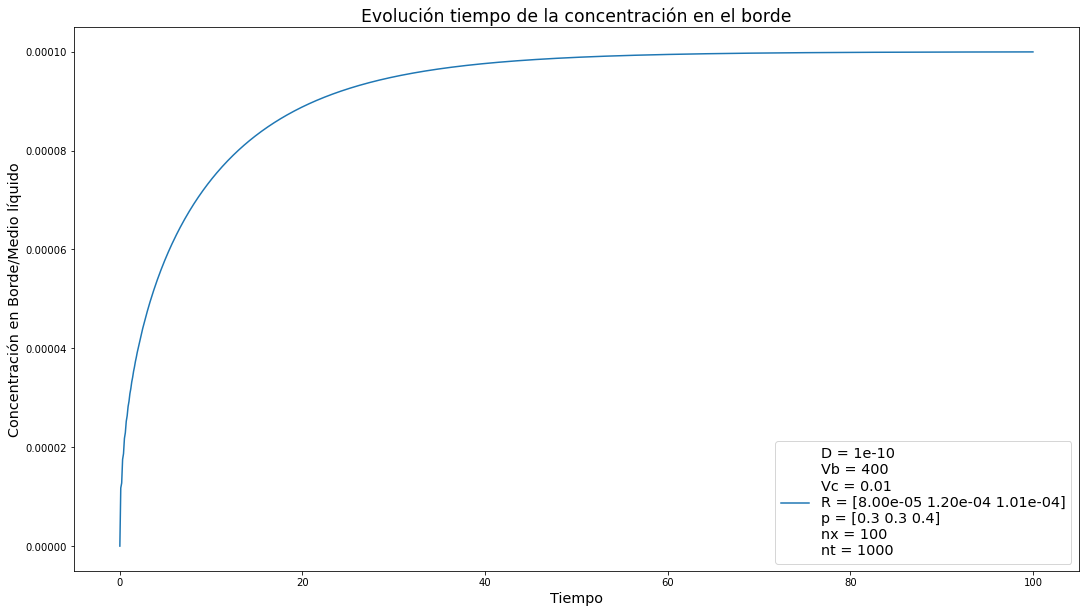

In [10]:
fig2 = plt.figure(figsize=(18,10))
plt.plot(np.linspace(0, T, nt), K)

plt.title("Evolución tiempo de la concentración en el borde", fontsize= "xx-large")
plt.legend([f"D = {10**(-10)}\nVb = {Vb}\nVc = {Vc}\nR = {Rit}\np = {pit}\nnx = {nx}\nnt = {nt}"], fontsize = "x-large")

plt.xlabel('Tiempo', fontsize = "x-large")
plt.ylabel('Concentración en Borde/Medio líquido', fontsize = "x-large")

plt.show()

In [11]:
# Parámetro para ajustar el tiempo máximo de visualización
ntmax = 999

dt = T/(nt-1) 
J = np.stack(J)
def h(T):
    
    fig = plt.figure(figsize=(25,7))
    fig.suptitle(f"Concentración interior en T = {T*dt}[s]\n",fontsize = "xx-large",linespacing=8)

    plt.subplot(1,3,1)
    
    x1 = np.linspace(0, Rit[0], nx)
    J1 = J[:,0:(nx-1)]
    J1 = np.append(J1,J[:,-1].reshape(J[:,-1].size,1),axis = 1)
    
    plt.plot(x1,J1[T,:], 'r-')
    
    plt.title(f"Ri = {Rit[0]}, pi = {pit[0]}", fontsize= "xx-large")
    
    plt.legend([f"D = {10**(-10)}\nVb = {Vb}\nVc = {Vc}"], fontsize = "x-large")
    
    plt.ylim(-0.1, 4.1)
    
    plt.xlabel('Interior del inmobilizador', fontsize = "x-large")
    plt.ylabel("Concentración en el interior", fontsize = "x-large")
    
    plt.subplot(1,3,2)
    
    x2 = np.linspace(0, Rit[1], nx)
    J2 = J[:,(nx-1):2*(nx-1)]
    J2 = np.append(J2,J[:,-1].reshape(J[:,-1].size,1),axis = 1)
    
    plt.plot(x2,J2[T,:], 'r-')
    
    plt.title(f"Ri = {Rit[1]:e}, pi = {pit[1]}", fontsize= "xx-large")
    
    plt.legend([f"D = {10**(-10)}\n"], fontsize = "x-large")
    
    plt.ylim(-0.1, 4.1)
    
    plt.xlabel('Interior del inmobilizador', fontsize = "x-large")
    plt.ylabel("Concentración en el interior", fontsize = "x-large")
    
    plt.subplot(1,3,3)
    
    x3 = np.linspace(0, Rit[1], nx)
    J3 = J[:,2*(nx-1):3*(nx-1)]
    J3 = np.append(J3,J[:,-1].reshape(J[:,-1].size,1),axis = 1)
    
    plt.plot(x3,J3[T,:], 'r-')
    
    plt.title(f"Ri = {Rit[2]:e}, pi = {pit[2]}", fontsize= "xx-large")
    
    plt.legend([f"D = {10**(-10)}\nVb = {Vb}\nVc = {Vc}"], fontsize = "x-large")
    
    plt.ylim(-0.1, 4.1)
    
    plt.xlabel('Interior del inmobilizador', fontsize = "x-large")
    plt.ylabel("Concentración en el interior", fontsize = "x-large")
    
    
iplot1 = interactive(h, T = (0,ntmax,1))
iplot1

interactive(children=(IntSlider(value=499, description='T', max=999), Output()), _dom_classes=('widget-interac…

## Comparación con el modelo de Grunwald ##

In [12]:
Rit3=np.linspace(0.01*R1,2*R1,100)
tgrid = np.linspace(0,T,nt)
def funcauxR1(t, n, D, Rit, c_0, c_inf, f):
    F = np.zeros(Rit.size,object)
    for rn in range(Rit.size):
        g = func1(t, D, n, Rit[rn], c_0, c_inf)
        errcont = simps((g-f)**2,t)
        errdis = ((g-f)**2).sum()
        F[rn]= np.array([errcont,errdis])
    F = np.stack(F) 
    #F_reshaped = F.reshape(F.shape[0], -1) 
    np.savetxt("SenR.txt", F) 
    return F
fgrunerrR1 = funcauxR1(tgrid, 16, D, Rit3, 0, J[-1,-1],J[:,-1])

In [13]:
def Y6(r):
    c_0 = 0
    c_inf= 4*Vc/(Vb+Vc)
    fgrun = func1(tgrid, D, 16, Rit3[r], 0, 4*Vc/(Vc+Vb))
    plt.figure(figsize = (25,7))
    plt.subplot(1,2,1)
    plt.plot(tgrid, fgrun, tgrid, J[:,-1], "r-")
    plt.plot(tgrid, func1(tgrid, D, 16, Rit.dot(pit), 0, 4*Vc/(Vc+Vb)),"k--")
    plt.legend([f"R_g = {Rit3[r]: e}",f"R_m = {Rit}\np = {pit}",f"promR = {Rit.dot(pit)}" ], fontsize = "x-large")
    plt.title("Evolución de la concentración en el borde")
    
    plt.xlabel('Tiempo', fontsize = "x-large")
    plt.ylabel("Concentración en el borde", fontsize = "x-large")
    plt.subplot(1,2,2)
    plt.title(f"Error continuo: Sol. Multiradio vs M. Grunwald R = {Rit3[r]:e}")
    
    plt.plot(Rit3, fgrunerrR1[:,0])
    plt.scatter(Rit3[r],fgrunerrR1[r,0])
    plt.plot(Rit[0]*np.ones(100),np.linspace(0,3.7*10**(-8),100),"g--")
    plt.plot(Rit[1]*np.ones(100),np.linspace(0,3.7*10**(-8),100),"r--")
    plt.plot(Rit[2]*np.ones(100),np.linspace(0,3.7*10**(-8),100),"y--")
    plt.plot(Rit.dot(pit)*np.ones(100),np.linspace(0,3.7*10**(-8),100),"k--")
    plt.legend([f"Error = {fgrunerrR1[r,0]}",f"Ri = {Rit[0]}, pi= {pit[0]}",f"Ri = {Rit[1]:e}, pi= {pit[1]}" ,f"Ri = {Rit[2]:e}, pi= {pit[2]}", f"promR = {Rit.dot(pit)}"])
    plt.plot(Rit3,np.zeros_like(fgrunerrR1[:,0]))
    plt.show()

iplot4 = interactive(Y6, r=(0,Rit3.shape[0]-1,1))
iplot4

interactive(children=(IntSlider(value=49, description='r', max=99), Output()), _dom_classes=('widget-interact'…

## Problema inverso para $D$: El método de la adjunta

Para encontrar $D$ en el caso de la ecuación multiradio utilizaremos el método del gradiente (para optimizar el funcional (2)), sin embargo para esto será necesario conocer el diferencial del funcional a minimizar, es aquí donde el método de la adjunta hace su aparación otorgando una herramienta para realizar este cálculo.

### El método

Sean

$$\begin{align}
    \phi = \left[S^{(1)},...,S^{(n_r)},S_b\right]^\top,\quad P = D 
\end{align}$$

y

$$\begin{equation}
    Y = \left(\prod_{i=1}^{n_r}C^1(0,T;L^2_{rad}(B_i))\cap L^2(0,T;H_{rad}^2(B_i))\right)\times C^1(0,T)\\
    Z =  \left(\prod_{i=1}^{n_r}L^2(0,T;L^2_{rad}(B_i))\times L^2(0,T)\right)\times L^2(0,T) \times \left(\prod_{i=1}^{n_r}L^2_{rad}(B_i)\right) \times \mathbb{R}
\end{equation}$$

*Observación:* Queda pendiente la verficación de esto pero es lo que se espera obtener de la wellpossednes mediante teoría de Semigrupos

Por otro lado sea $e: Y\times \mathbb{R} \to Z$ dada por

$$\begin{align}
    e(\phi, p) = \begin{pmatrix}
    S_t^{(i)}-D\Delta S^{(i)}\\
    -S^{(i)}(\sigma_i, \cdot) + S_b(\cdot)\\
    S_b'+ c\sum_{i=1}^{n_r} p_iR_i^2 \partial_n S^{(i)}(\sigma_i,\cdot)\\
    S^{(i)}(\cdot,0)-S_0^{(i)}\\
    S_b(0)-S_{b0}
    \end{pmatrix}
\end{align}$$

*Observación:* Escribimos la función así por comodidad de notación, se deben considerar las entradas 1, 2 y 4 para cada $i=1,...,n_r$.

el problema que queremos resolver está dado por

$$\begin{align*}
    &\min_{D\geq 0} J(\phi,P):=\dfrac{1}{2}\int_0^T|S_b(t)-g(t)|^2dt\\
    &s.a\quad e(\phi,P) = 0
\end{align*}$$

notemos que la condición a la cual está sujeta el problema de minimización es justamente el sistema multiradio definido en (4) en coordenadas cartesianas.

**Supuestos**

Asumiremos que

1. $e(\phi,P) = 0$ tiene única solución $\phi(P)$,
2. $\dfrac{\partial e}{\partial \phi}(\phi(P),P)\in \mathcal{L}(Y,Z)$ y es continuamente invertible

con esto se puede demostrar que el vector 

$$ \lambda = [\lambda_1^{(i)}(x,t),\lambda_2^{(i)},\lambda_3(t),\lambda_4^{(i)}(x),\lambda_5]^\top $$

*Observación:* Se usa la misma simplificación que usamos para $e$

solución de 


**Sistema adjunto**

Mediante la aplicación del producto dual en (7) e integraciones por parte obtendremos la siguiente relación entre las entradas del vector $\lambda$

$$\begin{align} 
    \left\{
    \begin{array}{lcll}
        -\partial_t\lambda_1^{(i)}=D\Delta \lambda_1^{(i)}  &\textrm{ en }&(0, T)\times B_i,\quad i=1,..., nr\\
      \lambda_3(t, 0)=\dfrac{4\pi D}{c}\lambda_1^{(i)}(t, \sigma_i) &\textrm{en}& (0, T)\times \partial B_i,\quad i=1,..., nr\\
        \lambda_3'(t)=4\pi D\sum_{i=1}^{n_r} p_iR_i^2 \partial_n \lambda_1^{(i)}(t,\sigma_i)+ g-S_b &\textrm{en}& (0, T)\times \partial B_i\\
        \lambda_1^{(i)}(T, x_i) = 0 &\textrm{en}& B_i,\quad i=1,..., nr\\
        \lambda_3(T) = 0,
    \end{array}
    \right.
    \tag{9}
\end{align}$$

la cual es denominada ecuación adjunta. Además 
$$\begin{align}
\lambda_4 = \lambda_3(0),\quad \lambda_2^{(i)} = 4\pi DR_i^2\partial_n\lambda_1^{(i)}, \quad \lambda_4^{(i)}(x_i)=\lambda_1^{(i)}(0,x_i)  
\end{align}$$

para $i=1,...,n_r$ y $x_i\in B_i$. Notemos que mediante el cambio de variables $s=T-t$ obtenemos el sistema retrógrado

$$\begin{align}
    \left\{
    \begin{array}{lcll}
        \partial_s\lambda_1^{(i)}=D\Delta \lambda_1^{(i)}  &\textrm{ en }&(0, T)\times B_i,\quad i=1,..., nr\\
          \lambda_3(s, 0)=\dfrac{4\pi D}{c}\lambda_1^{(i)}(s, \sigma_i) &\textrm{en}& (0, T)\times \partial B_i,\quad i=1,..., nr\\
        \lambda_3'(s)=-4\pi D\sum_{i=1}^{n_r} p_iR_i^2 \partial_n \lambda_1^{(i)}(s,\sigma_i) +g(T-s) - S_b(T-s) &\textrm{en}& (0, T)\times \partial B_i\\
        \lambda_1(0, x_i)^{(i)}= 0 &\textrm{en}& B_i,\quad i=1,..., nr\\
        \lambda_3(0) = 0,
    \end{array}
    \right.
    \tag{10}
\end{align}$$

**Dirección de minimización**

Utilizando la misma estrategia anterior con (8) y (9) se puede demostrar que 

$$\begin{align}
    \hat{J}'(D) &= \sum_{i=1}^{n_r}\left( -p_i \int_0^T\int_{B_i}\Delta S^{(i)}\lambda_1^{(i)}dxdt + \dfrac{cp_iR_i^2}{D}\int_0^T\partial_nS^{(i)}(\sigma_i,t)\lambda_3(t)dt\right)\\
     &= -\dfrac{1}{D}\int_0^TS_b'\lambda_3dt-\sum_{i=1}^{n_r}p_i \int_0^T\int_{B_i} \partial_tS^{(i)}\lambda_1^{(i)}dxdt
\end{align}$$

### Implementación: ##

El sistema (10) desacoplado tiene la misma forma que el sistema (5) exceptuando el término $g-S_b$, como este es un término de fuente en el borde podemos agregarlo sin la necesidad de generar nuevas matrices $A$ y $B$, esto queda plasmado en

In [16]:
def CN_2OmultRad(Sb, nx, nt, Vc, Vb, R, D, T, p, g):
     
    #Constantes utilizadas 
    A = m_AmultR(nx, nt , Vc, Vb, T, R, D, p)
    B = m_BmultR(nx, nt , Vc, Vb, T, R, D, p)
    #Construcción de las matrices
    #A = m_unif_A(nx, sigma1, sigma2, D, c)
    #B = m_unif_B(nx,sigma1,sigma2,D,c)
    dt = T/(nt-1)
    #Creación de arreglos para guardar la información
    wb = np.zeros(nt)
    wA = np.zeros(nt,object)
    w =  np.zeros((nx-1)*Rit.shape[0]+1)
    #Iteración temporal 
    for t in range(nt):
        
        #Se guarda la información
        wA[t] = np.array(w)
        wb[t] = w[-1]   
        aux3 = (3.)*Vc*dt/(Vb*(R**3).dot(p)*4*np.pi) 
        #Se calcula el lado derecho de (6)
        b = (-B).dot(w) 
        b[-1] = b[-1] + aux3*(g[-t]-Sb[-t])
        
        #Se encuentra el vector S^{n+1}
        w = solve(A,b)
        
    return w, wb, wA

Resolvemos el sistema

In [17]:
Had, Kad, Jad = CN_2OmultRad(K, nx, nt, Vc, Vb, Rit, D, T, pit, K*1.1)

Creamos una función auxiliar para calcular $\hat{J'}(P)$

In [18]:
def integrate3(SA, wA, nt, nx, T, R, D, Vc, Vb,p):
    Rshape = R.shape[0] 
    Nx = (nx-1)*Rshape + 1
    #c = 3*Vc*D/(R*Vb)
    #dx = R/(nx-1)
    #sigma = 1./(dx**2.)
    dt = T/(nt-1)
    t = np.linspace(0, T ,nt)
    
    SA = np.stack(SA, axis = 0) 
    
    
    wA = np.flipud(np.stack(wA, axis = 0))
    int1 = 0
    int2 = 0
    DS = (1./dt)*(SA[1:,:]-SA[:-1,:])
    DS = np.append(DS, [(1./dt)*(SA[-1,:]-SA[-2,:])], axis=0)
    for i in range(Rshape):
        #Primera fila i=0
        dxi = R[i]/(nx-1)
        aux = i*(nx-1)
        ri = np.linspace(0, R[i] ,nx)
        
        DSi = DS[:,i*(nx-1):(i+1)*(nx-1)]
        DSi = np.append(DSi,DS[:,-1].reshape(DS[:,-1].size,1), axis = 1)
        wAi = wA[:,i*(nx-1):(i+1)*(nx-1)]
        wAi = np.append(wAi,wA[:,-1].reshape(wA[:,-1].size,1),axis = 1)
        int1 += -(1./D)*4*np.pi*simps(simps((ri**2)*DSi*wAi, ri), t)*p[i]
    aux3 = (3.)*Vc/(Vb*(R**3).dot(p)*4*np.pi)
    int2 = -(1./D)*simps(DS[:,-1]*wA[:,-1], t)*aux3**(-1) 
    #print(int1+int2)
    return int1+int2

Y por último implementamos el algoritmo del gradiente

In [19]:
from scipy.optimize import minimize, fmin_cg 
Sin = np.ones(nx)*4
Sin[-1] = Sb0
def funmin(D1):
    global dconv
    global fconv
    S1, Sb1, SA1 = CN_2OmultR(Sin2, nx, nt, Vc, Vb, Rit, D1, T, pit)
    intr = (1./2)*simps((Sb1 - K)**2,np.linspace(0, T, nt))
    #print(f"Func = {intr}, Dn = {D1}")
    dconv = np.append(dconv,[D1])
    fconv = np.append(fconv,[intr])
    return (1./2)*simps((Sb1 - K)**2,np.linspace(0, T, nt))
def gradfun(D1):
    global gradconv
    S1, Sb1, SA1 = CN_2OmultR(Sin2, nx, nt, Vc, Vb, Rit, D1, T, pit)
    w1, wb1, wA1 =  CN_2OmultRad(Sb1, nx, nt, Vc, Vb, Rit, D1, T, pit, K)
    DJ = a*integrate3(SA1, wA1, nt, nx, T, Rit, D1, Vc, Vb,pit)#print(D1)
    #print(f"gradJn = {DJ}")
    gradconv = np.append(gradconv,[DJ/a])
    return DJ

In [20]:
a = 10**(-13)
dconv = []
gradconv = []
fconv = []
res = minimize(funmin, D*1.1, method = 'CG', jac = gradfun, options={"gtol":1e-16})

In [21]:
res

     fun: 1.0077522453637651e-19
     jac: array([5.00168824e-17])
 message: 'Optimization terminated successfully.'
    nfev: 27
     nit: 8
    njev: 27
  status: 0
 success: True
       x: array([1.00000406e-10])

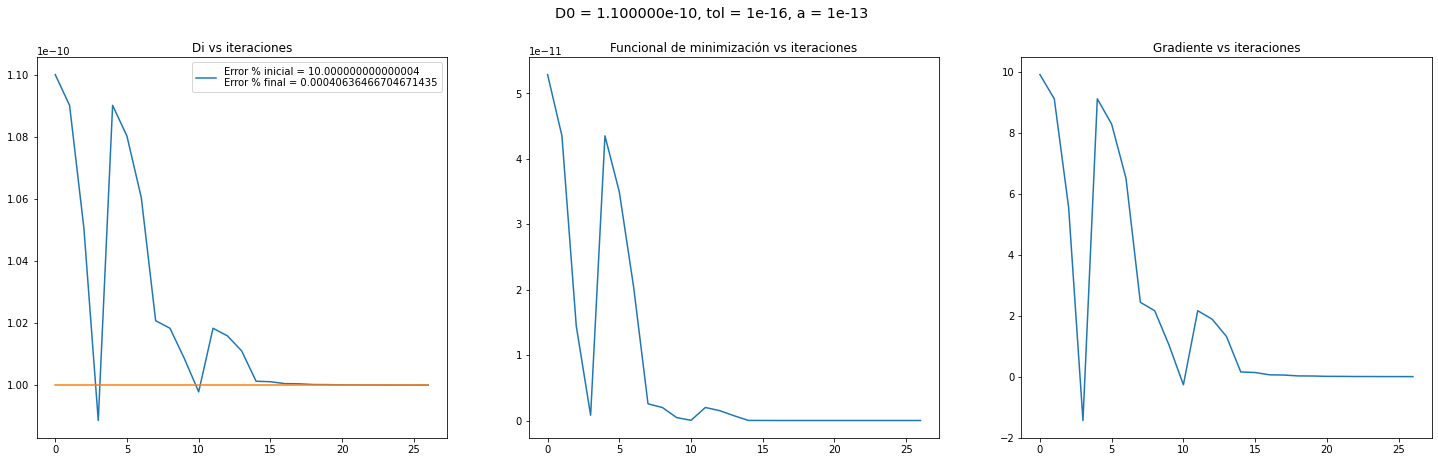

In [22]:
plt.figure(figsize=(25,7))
plt.suptitle(f"D0 = {1.1*D:e}, tol = {10**(-16)}, a = {10**(-13)}", fontsize = "x-large")
plt.subplot(1,3,1)
plt.plot(dconv)
plt.plot(np.ones_like(dconv)*D)
plt.title("Di vs iteraciones")
plt.legend([f"Error % inicial = {np.absolute(dconv[0]-D)/D*100}\nError % final = {np.absolute(dconv[-1]-D)/D*100}"])
plt.subplot(1,3,2)
plt.plot(fconv)
plt.title("Funcional de minimización vs iteraciones", fontsize = "large")
plt.subplot(1,3,3)
plt.plot(gradconv)
plt.title("Gradiente vs iteraciones")
plt.show()

In [24]:
dconv = []
gradconv = []
fconv = []
res1 = minimize(funmin, D*1.3, method = 'CG', jac = gradfun, options={"gtol":1e-16})
res1

     fun: 8.569844409826977e-20
     jac: array([4.61239407e-17])
 message: 'Optimization terminated successfully.'
    nfev: 28
     nit: 10
    njev: 28
  status: 0
 success: True
       x: array([1.00000375e-10])

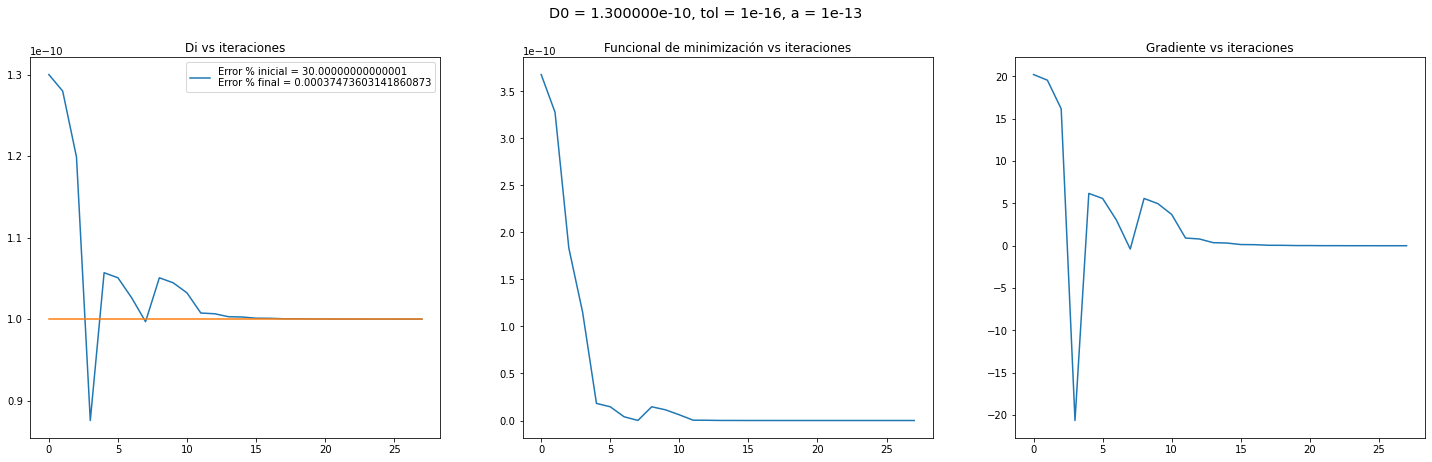

In [25]:
plt.figure(figsize=(25,7))
plt.suptitle(f"D0 = {1.3*D:e}, tol = {10**(-16)}, a = {10**(-13)}", fontsize = "x-large")
plt.subplot(1,3,1)
plt.plot(dconv)
plt.plot(np.ones_like(dconv)*D)
plt.title("Di vs iteraciones")
plt.legend([f"Error % inicial = {np.absolute(dconv[0]-D)/D*100}\nError % final = {np.absolute(dconv[-1]-D)/D*100}"])
plt.subplot(1,3,2)
plt.plot(fconv)
plt.title("Funcional de minimización vs iteraciones", fontsize = "large")
plt.subplot(1,3,3)
plt.plot(gradconv)
plt.title("Gradiente vs iteraciones")
plt.show()

In [26]:
dconv = []
gradconv = []
fconv = []
res2 = minimize(funmin, D*0.7, method = 'CG', jac = gradfun, options={"gtol":1e-16})
res2

     fun: 7.679484453247186e-20
     jac: array([-4.36627186e-17])
 message: 'Optimization terminated successfully.'
    nfev: 23
     nit: 11
    njev: 23
  status: 0
 success: True
       x: array([9.99996453e-11])

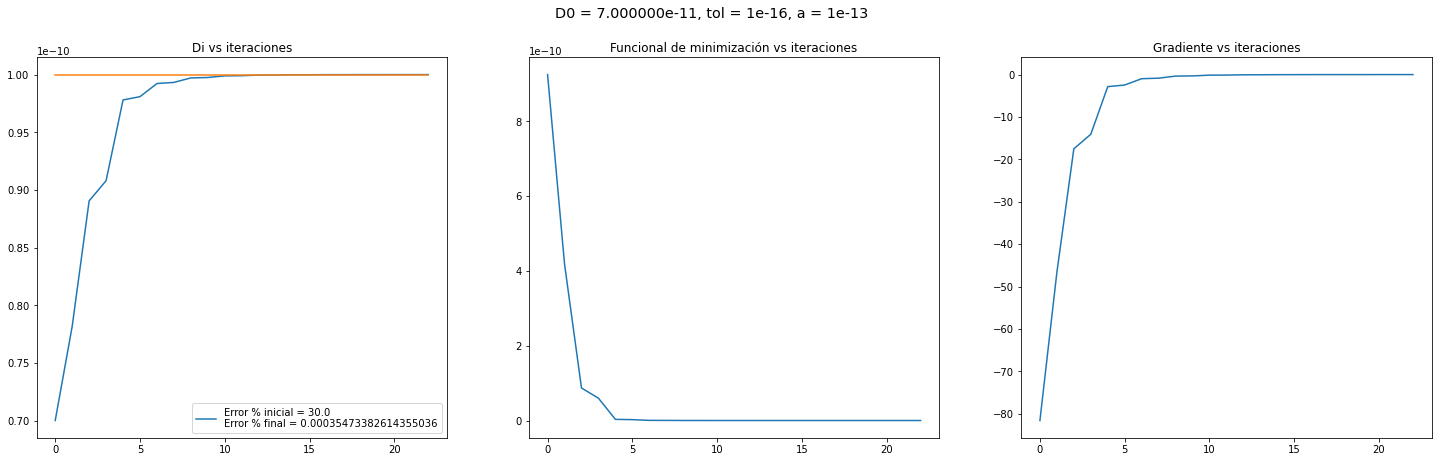

In [27]:
plt.figure(figsize=(25,7))
plt.suptitle(f"D0 = {0.7*D:e}, tol = {10**(-16)}, a = {10**(-13)}", fontsize = "x-large")
plt.subplot(1,3,1)
plt.plot(dconv)
plt.plot(np.ones_like(dconv)*D)
plt.title("Di vs iteraciones")
plt.legend([f"Error % inicial = {np.absolute(dconv[0]-D)/D*100}\nError % final = {np.absolute(dconv[-1]-D)/D*100}"])
plt.subplot(1,3,2)
plt.plot(fconv)
plt.title("Funcional de minimización vs iteraciones", fontsize = "large")
plt.subplot(1,3,3)
plt.plot(gradconv)
plt.title("Gradiente vs iteraciones")
plt.show()

In [28]:
Kr = K + np.random.normal(0, Vc/(Vb+Vc)*0.1, nt)
def funminr(D1):
    global dconv
    global fconv
    S1, Sb1, SA1 = CN_2OmultR(Sin2, nx, nt, Vc, Vb, Rit, D1, T, pit)
    intr = simps((Sb1 - Kr)**2,np.linspace(0, T, nt))
    dconv = np.append(dconv,[D1])
    fconv = np.append(fconv,[intr])
    return simps((Sb1 - Kr)**2,np.linspace(0, T, nt))
def gradfunr(D1):
    global gradconv
    S1, Sb1, SA1 = CN_2OmultR(Sin2, nx, nt, Vc, Vb, Rit, D1, T, pit)
    w1, wb1, wA1 =  CN_2OmultRad(Sb1, nx, nt, Vc, Vb, Rit, D1, T, pit, Kr)
    DJ = a*integrate3(SA1, wA1, nt, nx, T, Rit, D1, Vc, Vb,pit)#print(D1)
    gradconv = np.append(gradconv,[DJ/a])
    return DJ

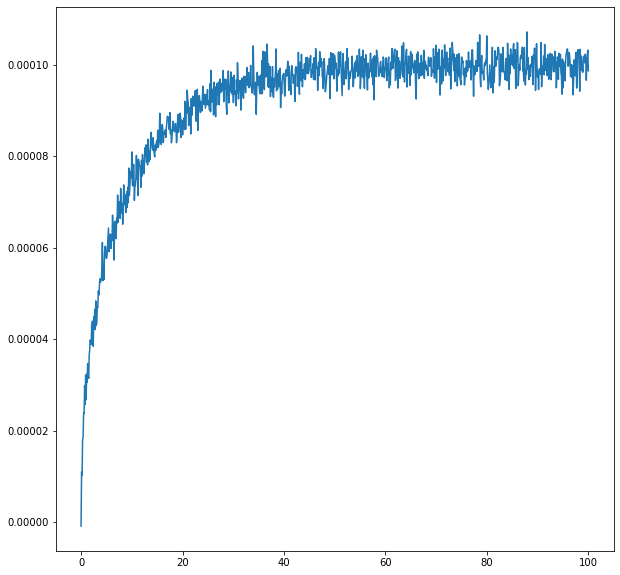

In [37]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0, T, nt), Kr)
plt.show()

In [30]:
dconv = []
gradconv = []
fconv = []
res = minimize(funminr, D*1.1, method = 'CG', jac = gradfunr, options={"gtol":1e-16})

In [31]:
res

     fun: 6.286222232324515e-10
     jac: array([2.60896042e-15])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 114
     nit: 4
    njev: 102
  status: 2
 success: False
       x: array([1.00172971e-10])

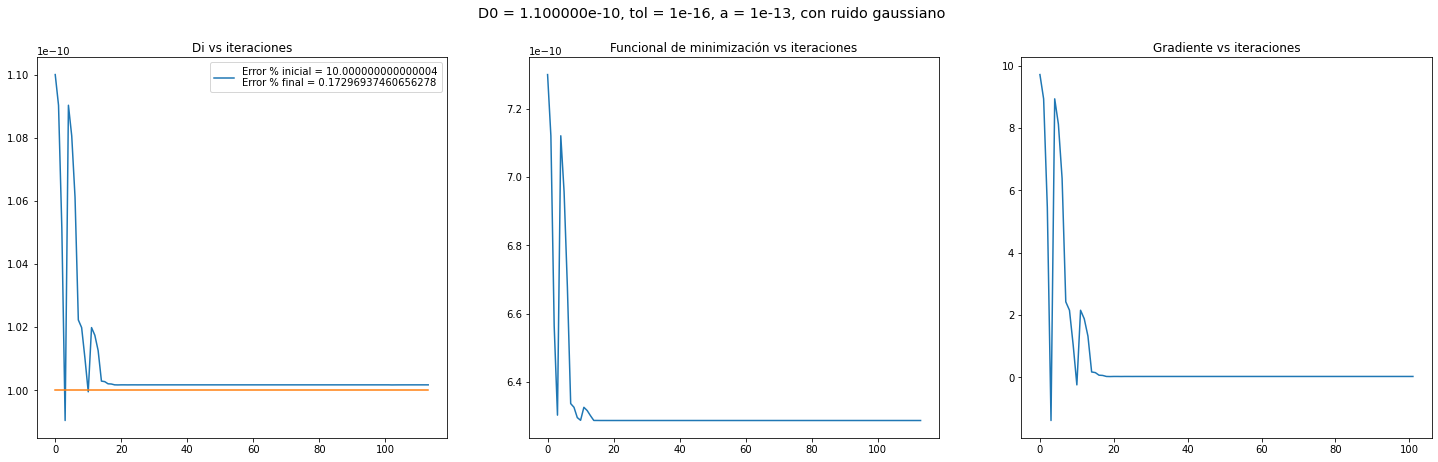

In [32]:
plt.figure(figsize=(25,7))
plt.suptitle(f"D0 = {1.1*D:e}, tol = {10**(-16)}, a = {10**(-13)}, con ruido gaussiano", fontsize = "x-large")
plt.subplot(1,3,1)
plt.plot(dconv)
plt.plot(np.ones_like(dconv)*D)
plt.title("Di vs iteraciones")
plt.legend([f"Error % inicial = {np.absolute(dconv[0]-D)/D*100}\nError % final = {np.absolute(dconv[-1]-D)/D*100}"])
plt.subplot(1,3,2)
plt.plot(fconv)
plt.title("Funcional de minimización vs iteraciones", fontsize = "large")
plt.subplot(1,3,3)
plt.plot(gradconv)
plt.title("Gradiente vs iteraciones")
plt.show()

In [33]:
dconv = []
gradconv = []
fconv = []
res1 = minimize(funminr, D*1.3, method = 'CG', jac = gradfunr, options={"gtol":1e-16})
res1

     fun: 6.286222984571789e-10
     jac: array([3.64679014e-15])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 40
     nit: 3
    njev: 29
  status: 2
 success: False
       x: array([1.00181478e-10])

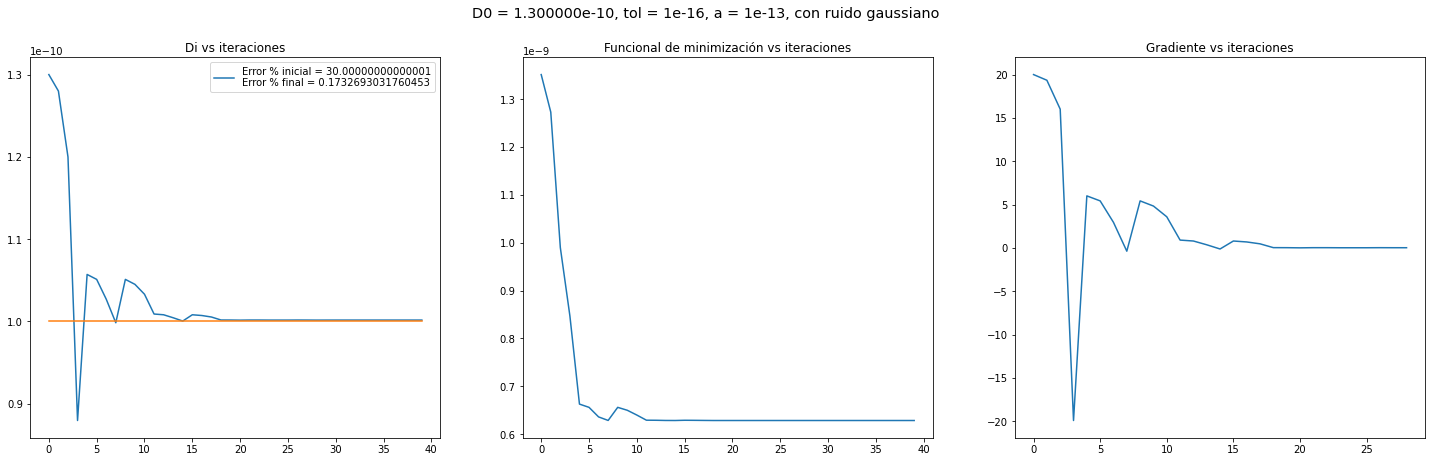

In [34]:
plt.figure(figsize=(25,7))
plt.suptitle(f"D0 = {1.3*D:e}, tol = {10**(-16)}, a = {10**(-13)}, con ruido gaussiano", fontsize = "x-large")
plt.subplot(1,3,1)
plt.plot(dconv)
plt.plot(np.ones_like(dconv)*D)
plt.title("Di vs iteraciones")
plt.legend([f"Error % inicial = {np.absolute(dconv[0]-D)/D*100}\nError % final = {np.absolute(dconv[-1]-D)/D*100}"])
plt.subplot(1,3,2)
plt.plot(fconv)
plt.title("Funcional de minimización vs iteraciones", fontsize = "large")
plt.subplot(1,3,3)
plt.plot(gradconv)
plt.title("Gradiente vs iteraciones")
plt.show()

In [35]:
a=10**(-14)

dconv = []
gradconv = []
fconv = []
res2 = minimize(funminr, D*0.7, method = 'CG', jac = gradfunr, options={"gtol":1e-16})
res2

     fun: 6.286228102894363e-10
     jac: array([-7.04617731e-19])
 message: 'Optimization terminated successfully.'
    nfev: 16
     nit: 4
    njev: 16
  status: 0
 success: True
       x: array([1.00151541e-10])

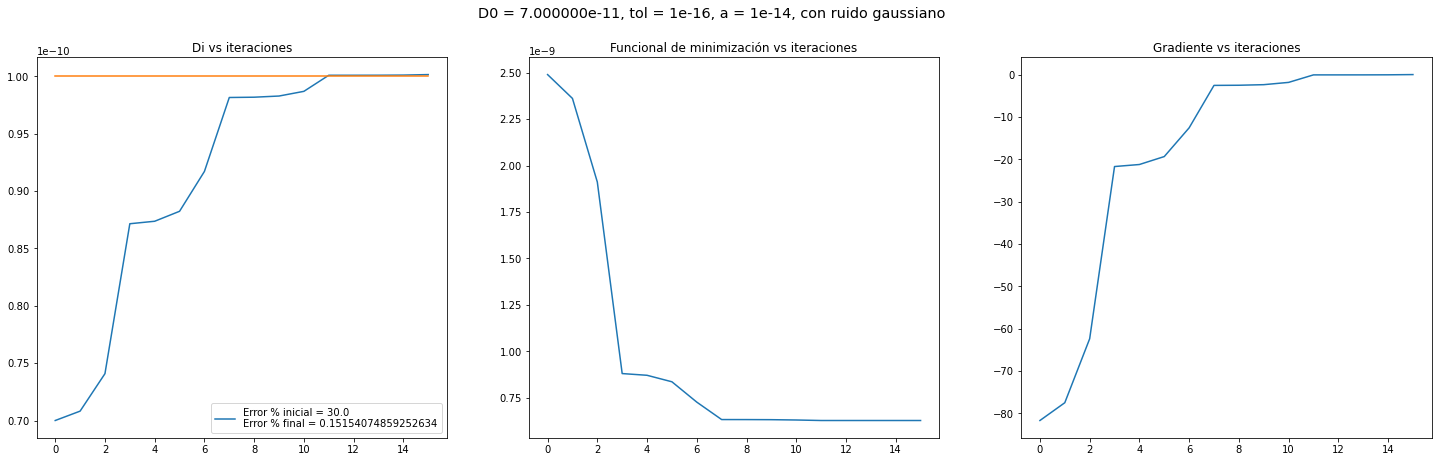

In [36]:
plt.figure(figsize=(25,7))
plt.suptitle(f"D0 = {0.7*D:e}, tol = {10**(-16)}, a = {a}, con ruido gaussiano", fontsize = "x-large")
plt.subplot(1,3,1)
plt.plot(dconv)
plt.plot(np.ones_like(dconv)*D)
plt.title("Di vs iteraciones")
plt.legend([f"Error % inicial = {np.absolute(dconv[0]-D)/D*100}\nError % final = {np.absolute(dconv[-1]-D)/D*100}"])
plt.subplot(1,3,2)
plt.plot(fconv)
plt.title("Funcional de minimización vs iteraciones", fontsize = "large")
plt.subplot(1,3,3)
plt.plot(gradconv)
plt.title("Gradiente vs iteraciones")
plt.show()